In [1]:
from pycqed import *
import networkx as nx
import qutip as qt
import itertools as itt
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as cl
import matplotlib.cm as cm
import numpy as np

In [2]:
mpl.rcParams.update({'font.size':20}) # This sometimes needs to be run twice to make it work

In [3]:
mpl.rcParams.update({'font.size':20}) # This sometimes needs to be run twice to make it work

### Single Qubit Annealing

The simplest example to demonstrate the functionality of the `IsingGraph` and `QuantumAnnealing` classes is the case of single qubit annealing. A flux qubit can be approximated by a single spin Hamiltonian in small range of external fluxes. In an annealing context, the spin level Hamiltonian can be described:

$$\hat{H}(s)=A(s)\hat{\sigma}_x+B(s)\hat{\sigma}_z$$

where

$$s = \frac{t}{t_\mathrm{an}}$$

is the normalised annealing time and $A(s)$ and $B(s)$ are the energy annealing schedules. Colleagues at USC have shown that it may be possible to reveal coherence effects using this system by measuring the ground state population as a function of annealing time $t_\mathrm{an}$.

In the case that there is no decoherence in the system, i.e. the system is closed, the Schrödinger equation is used (`mesolve` defaults to `sesolve`). This equation uses the state vector formalism:

$$\mathrm{i}\hbar \frac{\partial}{\partial t} |\psi\rangle = \hat{H} |\psi\rangle $$

which is very difficult to solve analytically in general when the Hamiltonian is time-dependent. In all annealing cases we will do this numerically.

First we can define our hardware graph using `IsingGraph`, which in this case consists of a single node:

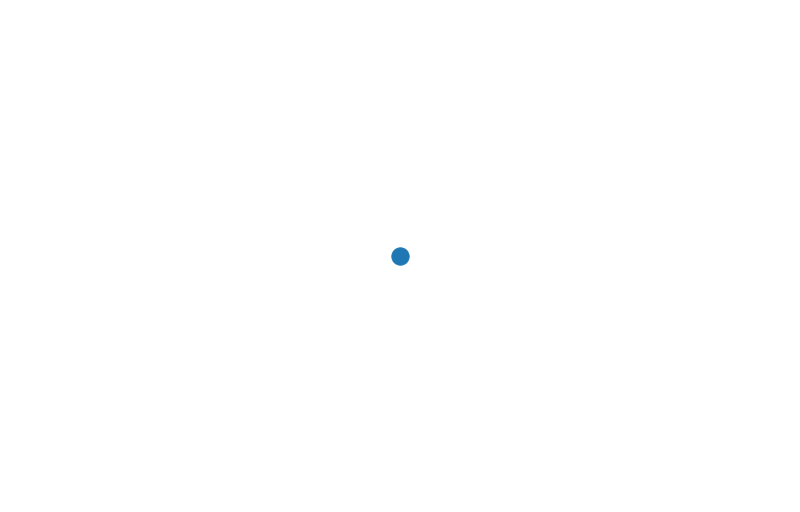

In [4]:
G = nx.Graph()
G.add_node(0)

# Draw the graph
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
nx.draw(G, ax=ax)

Now we use this graph to initialise the driver and problem terms:

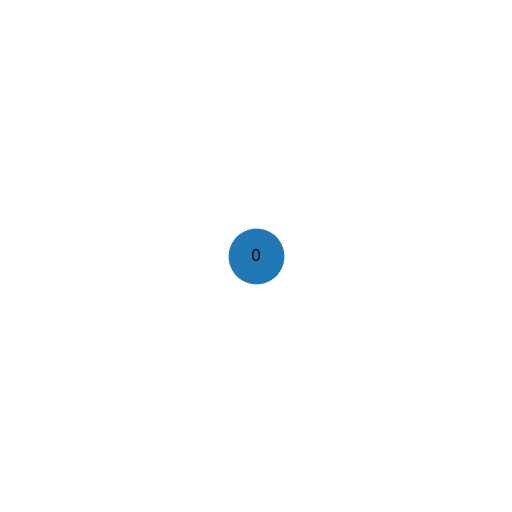

In [5]:
# Initialise the data structures
P = IsingGraph({1:G, 2:G})
D = IsingGraph({1:G, 2:G})

# Draw the problem graph
P.drawNthOrderGraph(1)

We see that we have created a default hardware Ising graph with all coefficients set to zero, which gives us a Hamiltonian equal to $\hat{0}$:

In [6]:
P.getHamiltonian()

0.0

Now lets set the coefficients of the Hamiltonian to 1 GHz, using node 0 as the label:

In [7]:
D.setCoef(0, 'hx', 1)
P.setCoef(0, 'hz', 1)

In [8]:
D.getHamiltonian()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.         6.28318531]
 [6.28318531 0.        ]]

In [9]:
P.getHamiltonian()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 6.28318531  0.        ]
 [ 0.         -6.28318531]]

Where now we see the terms have been set.

Now we will use linear schedules to connect the driver and problem graphs we have defined:

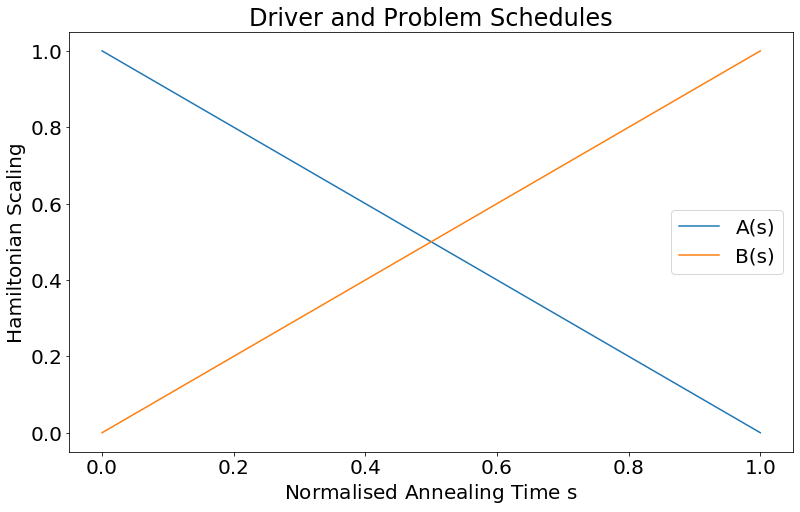

In [10]:
tan = 30.0 # Total annealing time in ns
schedule_params = {"tan":tan,"stype":"linear"} # Schedule parameters
anneal_times = np.linspace(0,tan,101) # Time points

# Plot the schedules
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
ax.plot(anneal_times/tan, [A(t, schedule_params) for t in anneal_times], label="A(s)")
ax.plot(anneal_times/tan, [B(t, schedule_params) for t in anneal_times], label="B(s)")
ax.set_xlabel('Normalised Annealing Time $s$')
ax.set_ylabel('Hamiltonian Scaling')
ax.set_title('Driver and Problem Schedules')
ax.legend()

These schedules as defined currently will appear as prefactors to the entire driver and problem graphs, in the general form

$$\hat{H}(s) = A(s) \hat{H}_D + B(s) \hat{H}_P$$

This is the simplest and most general way to describe an annealing process. Later we will look into the use of realistic qubits derived from superconducting circuits, using reduction techniques.

Now we can initialise the annealing class which wraps the time evolution solvers and conveniently formats the results in commonly used forms.

In [11]:
Qs = QuantumAnnealing(P, D, schedule_params)
Qs.setSolverOptions(qt.sesolve)

First we can look at the instaneous energies during an annealing process using the `annealInstantaneousGap` function:

Text(0.5, 1.0, 'Instantaneous Gaps')

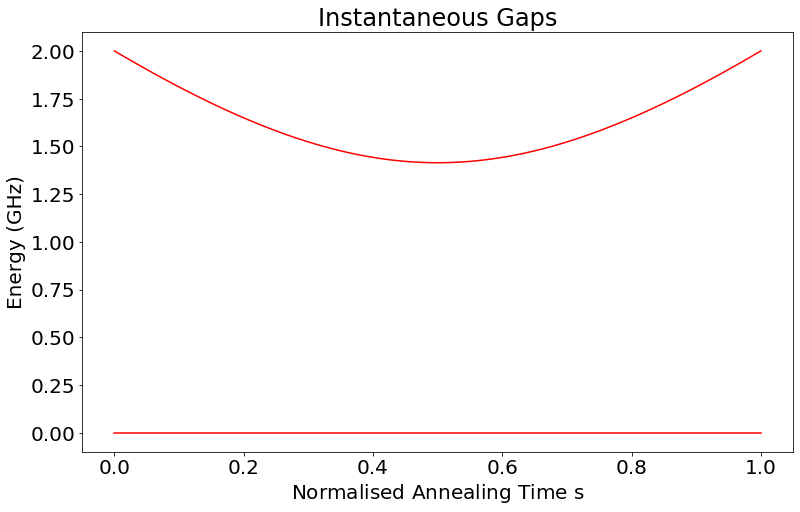

In [12]:
Emis = Qs.annealInstantaneousGap(anneal_times)

fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
for i in range(2):
    ax.plot(anneal_times/tan, Emis[i], "r-")
ax.set_xlabel('Normalised Annealing Time $s$')
ax.set_ylabel('Energy (GHz)')
ax.set_title('Instantaneous Gaps')

We can look at the probability of observing a given state of our single qubit as function of the total annealing time using `annealStateProbability`, which is effectively as a function of the rate at which the connection is made between the driver and problem Hamiltonians.

In [13]:
Qs.Vp[0]

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[ 0.]
 [-1.]]

In [14]:
anneal_times = np.linspace(0.001,3.0,101)
anneal_prob = Qs.annealStateProbability(anneal_times, timesweep=True)

Sweep Duration:
  Initialization:	0.000 s
  Loop duration:	0.184 s
  Avg iteration:	0.002 s


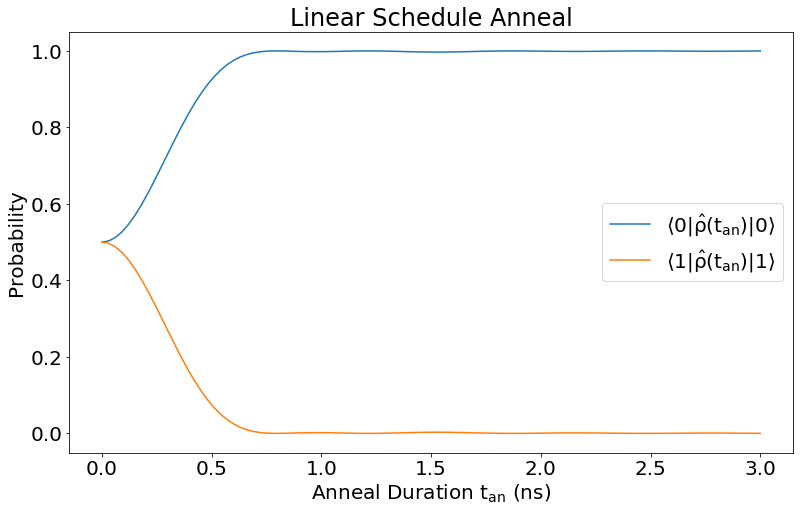

In [15]:
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
for i in range(2):
    ax.plot(anneal_times, anneal_prob[i], label="$\\langle %i | \hat{\\rho}(t_{an}) | %i \\rangle$" % (i,i))
ax.set_xlabel('Anneal Duration $t_{an}$ (ns)')
ax.set_ylabel('Probability')
ax.set_title('Linear Schedule Anneal')
ax.legend()

To look at the probability of observing a state, we can use the `evolveStateProbability` function, here for a given value of annealing time, i.e. a set rate.

In [16]:
tan = 1.0 # Total annealing time in ns
schedule_params = {"tan":tan,"stype":"linear"} # Schedule parameters
times = np.linspace(0,tan,101) # Time points
prob = Qs.evolveStateProbability(times, timesweep=True, sparams=schedule_params)

Sweep Duration:
  Initialization:	0.001 s
  Loop duration:	0.064 s
  Avg iteration:	0.001 s


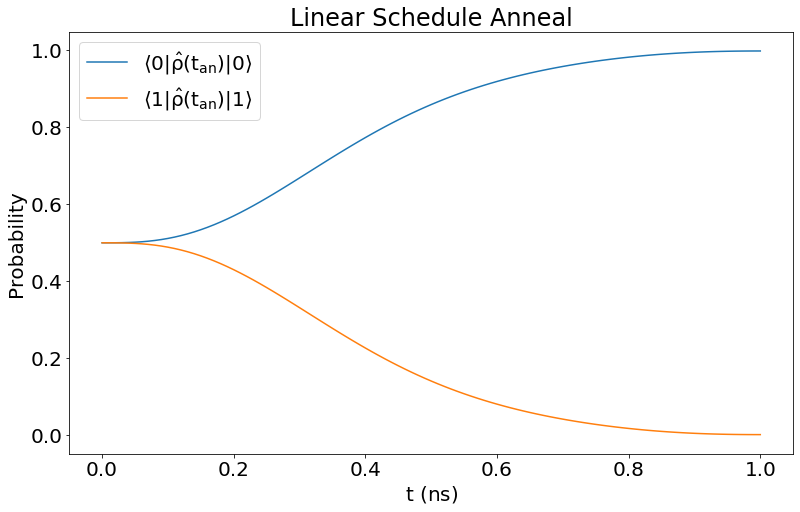

In [17]:
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
for i in range(2):
    ax.plot(times, prob[i], label="$\\langle %i | \hat{\\rho}(t_{an}) | %i \\rangle$" % (i,i))
ax.set_xlabel('$t$ (ns)')
ax.set_ylabel('Probability')
ax.set_title('Linear Schedule Anneal')
ax.legend()

The function `evolveOperatorExpectations` can be used to obtain the expectation values of given operators. In the case of a single qubit, this can be used to plot the state vector on a Bloch sphere:

In [18]:
tan = 10.0 # Total annealing time in ns
schedule_params = {"tan":tan,"stype":"linear"} # Schedule parameters
times = np.linspace(0,tan,101) # Time points
exp = Qs.evolveOperatorExpectations(times, [qt.sigmax(), qt.sigmay(), qt.sigmaz()], timesweep=True, sparams=schedule_params)

Sweep Duration:
  Initialization:	0.000 s
  Loop duration:	0.024 s
  Avg iteration:	0.000 s


First on a normal plot:

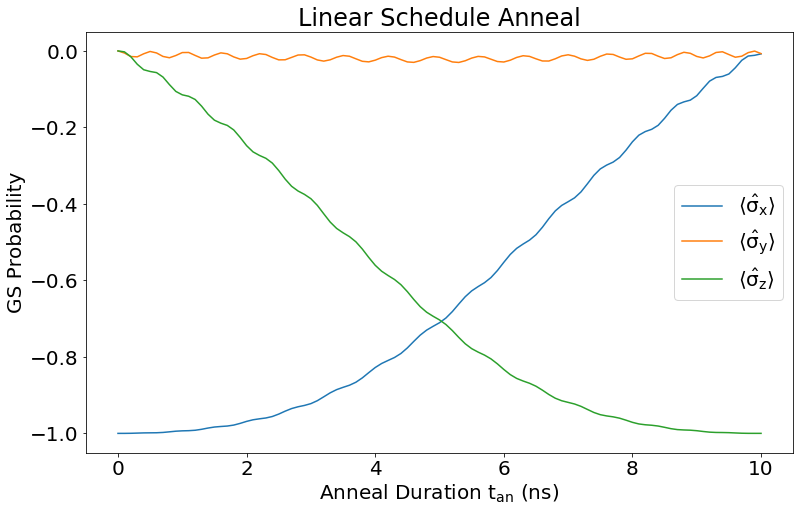

In [19]:
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
ax.plot(times, exp[0], label="$\\langle \hat{\\sigma}_x \\rangle$")
ax.plot(times, exp[1], label="$\\langle \hat{\\sigma}_y \\rangle$")
ax.plot(times, exp[2], label="$\\langle \hat{\\sigma}_z \\rangle$")
ax.set_xlabel('Anneal Duration $t_{an}$ (ns)')
ax.set_ylabel('GS Probability')
ax.set_title('Linear Schedule Anneal')
ax.legend()

Now on a Bloch sphere:

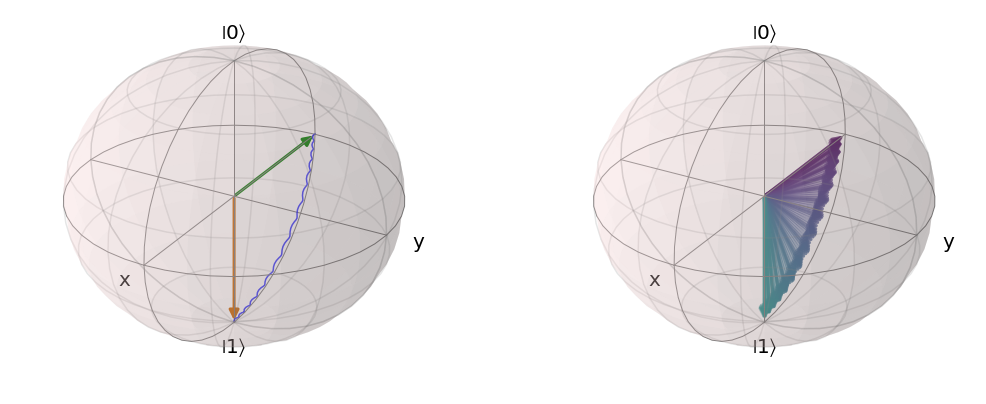

In [20]:
# Plot points and state vectors
fig = plt.figure(figsize=(15,7))
ax1 = plt.subplot(121,projection="3d")
ax2 = plt.subplot(122,projection="3d")

# Gen points from eigenvalues
sv_pts = [exp[0],exp[1],exp[2]]
b1 = qt.Bloch(fig=fig,axes=ax1)
b1.add_points(sv_pts,meth='l')
b1.add_vectors([exp[0][0],exp[1][0],exp[2][0]]) # add the state vector at t=0
b1.add_vectors([0,0,exp[2][-1]]) # add the projection of the state vector onto the sigmaz ground state at t=tan
b1.render(fig=fig,axes=ax1)

colors = cm.viridis(np.linspace(0, 1, 200))
cls = []
for c in colors:
    c[3] = 0.5
    cls.append(cl.to_hex(c,True))

# Gen vectors from eigenvalues
sv_vecs = [[exp[0][i],exp[1][i],exp[2][i]] for i in range(len(times))]
b2 = qt.Bloch(fig=fig,axes=ax2)
b2.vector_color = cls
b2.add_vectors(sv_vecs)
b2.render(fig=fig,axes=ax2)

Another quantity of interest is the time to solution, obtained using `timeToSolution`, where here we have defined the success rate as $99\%$.

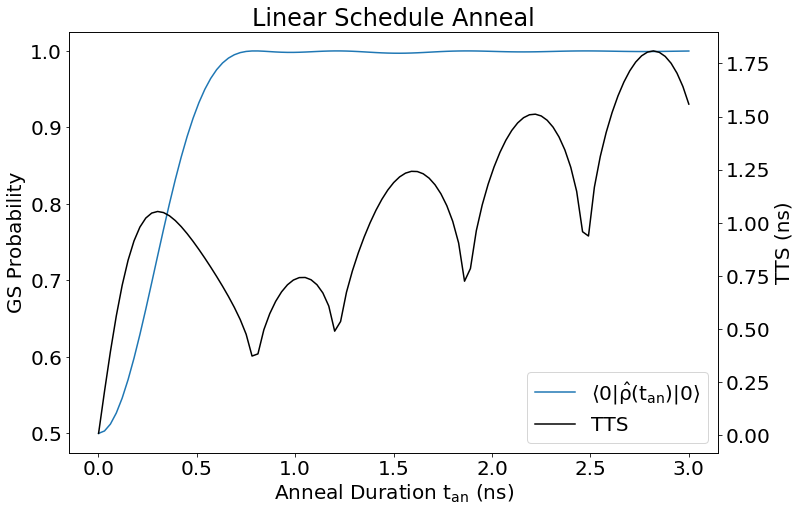

In [21]:
fig, ax = plt.subplots(1,1,constrained_layout=True,figsize=(11,7))
l1, = ax.plot(anneal_times, anneal_prob[0])
ax2 = ax.twinx()
l2, = ax2.plot(anneal_times, Qs.timeToSolution(anneal_times, anneal_prob[0]), 'k-')
ax.set_xlabel('Anneal Duration $t_{an}$ (ns)')
ax.set_ylabel('GS Probability')
ax2.set_ylabel('TTS (ns)')
ax.set_title('Linear Schedule Anneal')
ax.legend((l1,l2), ("$\\langle %i | \hat{\\rho}(t_{an}) | %i \\rangle$" % (0,0), "TTS"))

In [22]:
P.getBitString()

'0'